<a href="https://colab.research.google.com/github/VinodKumar9576/TMDB-Prediction/blob/master/TMDB Prediction/Modelling.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

* Importing the previously created data.

In [0]:
!pip install fastparquet
!pip install eli5

In [0]:
import fastparquet
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import eli5
from sklearn.model_selection import KFold

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of th

**Downloading sample submission file**

In [0]:
import getpass as gt

user = input('Provide Kaggle Username : ')
api = gt.getpass('API key for '+ user +' :')
print('')

!mkdir ~/.kaggle

!touch /root/.kaggle/kaggle.json

kaggle_api_key = {'username':user, 'key':api}


!chmod 600 /root/.kaggle/kaggle.json

import json

with open('/root/.kaggle/kaggle.json','w') as file:
  json.dump(kaggle_api_key, file)


!kaggle datasets download -d vinodkumar9576/tmdbboxofficeprediction

#api command for additional features folder download
!kaggle datasets download -d vinodkumar9576/tmdb-additional-features

from zipfile import ZipFile

for names in ZipFile('/content/tmdbboxofficeprediction.zip').namelist():
  print(names)

Provide Kaggle Username : vinodkumar9576
API key for vinodkumar9576 :··········

 34% 6.00M/17.4M [00:00<00:00, 61.1MB/s]
100% 17.4M/17.4M [00:00<00:00, 112MB/s] 
  0% 0.00/78.1k [00:00<?, ?B/s]
100% 78.1k/78.1k [00:00<00:00, 66.4MB/s]
sample_submission.csv
test.csv
train.csv


In [0]:
#Reading the sample_submission.csv from zipfile
with ZipFile('/content/tmdbboxofficeprediction.zip') as zip:
  sample_sub = pd.read_csv(zip.open('sample_submission.csv'))

In [0]:
if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Works/TMDB Prediction/data/IIstage_feat_train.parquet.gzip'):
  train = pd.read_parquet('/content/drive/My Drive/Colab Notebooks/Works/TMDB Prediction/data/IIstage_feat_train.parquet.gzip', engine = 'fastparquet')
else:
  print('Previous note book is not found. Please run the previous notebook')

if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Works/TMDB Prediction/data/IIstage_feat_test.parquet.gzip'):
  test = pd.read_parquet('/content/drive/My Drive/Colab Notebooks/Works/TMDB Prediction/data/IIstage_feat_test.parquet.gzip', engine = 'fastparquet')
else:
  print('Previous note book is not found. Please run the previous notebook')


In [0]:
train.head()

,id,budget,imdb_id,original_language,popularity,runtime,revenue,Collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,...,jobs_Screenplay,jobs_Editor,jobs_Casting,jobs_Director of Photography,jobs_Original Music Composer,jobs_Art Direction,jobs_Production Design,jobs_Costume Design,jobs_Writer,jobs_Set Decoration,jobs_Makeup Artist,jobs_Sound Re-Recording Mixer,departments_Production,departments_Sound,departments_Art,departments_Crew,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors,log_budget,has_homepage,release_date_year,release_date_weekday,release_date_month,release_date_weekofyear,release_date_day,release_date_quarter,len_title,words_title,len_tagline,words_tagline,len_overview,words_overview,len_original_title,words_original_title
0,1,14000000,tt2637294,10,6.575393,93.0,12314651,282,1,1,480,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1,4,2,9,10,12,4,2,13,8,4,2,4,4,0,16.454568,0,2015,4,2,8,20,1,22,38,52,86,155,243,22,38
1,2,40000000,tt0368933,10,8.248895,113.0,95149435,641,1,4,516,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,1,0,1,1,0,0,0,0,0,0,0,4,1,0,0,1,0,1,1,1,0,0,0,17.504390,0,2004,4,8,32,6,3,40,59,60,100,393,601,40,59
2,3,3300000,tt2582802,10,64.299990,105.0,13092000,0,0,1,658,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,1,1,1,1,1,0,1,1,2,18,9,5,9,1,5,4,3,6,3,1,0,15.009433,1,2014,4,10,41,10,4,8,12,47,78,130,194,8,12
3,4,1200000,tt1821480,16,3.174936,122.0,16000000,0,0,2,742,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,13.997833,1,2012,4,3,10,9,1,7,11,0,4,581,900,7,11
4,5,0,tt1380152,24,1.148070,118.0,3923970,0,0,2,295,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.000000,0,2009,3,2,6,5,1,10,17,0,4,168,265,4,8


In [0]:
test.head(2)

,id,budget,imdb_id,original_language,popularity,runtime,Collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,...,jobs_Screenplay,jobs_Editor,jobs_Casting,jobs_Director of Photography,jobs_Original Music Composer,jobs_Art Direction,jobs_Production Design,jobs_Costume Design,jobs_Writer,jobs_Set Decoration,jobs_Makeup Artist,jobs_Sound Re-Recording Mixer,departments_Production,departments_Sound,departments_Art,departments_Crew,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors,log_budget,has_homepage,release_date_year,release_date_weekday,release_date_month,release_date_weekofyear,release_date_day,release_date_quarter,len_title,words_title,len_tagline,words_tagline,len_overview,words_overview,len_original_title,words_original_title
0,3001,0,tt1226251,21,3.851534,90.0,420,1,4,320,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.000000,1,2007,5,7,28,14,3,28,44,51,79,335,507,18,22
1,3002,88000,tt0051380,10,3.559789,65.0,0,0,2,789,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,0,1,0,1,0,2,1,0,0,1,1,1,1,1,0,0,0,11.385103,0,1958,0,5,21,19,2,27,46,96,145,162,250,27,46


* **Loading the text columns files**

In [0]:
if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Works/TMDB Prediction/data/train_texts.parquet.gzip'):
  train_texts = pd.read_parquet('/content/drive/My Drive/Colab Notebooks/Works/TMDB Prediction/data/train_texts.parquet.gzip', engine = 'fastparquet')
else:
  print('Previous note book is not found. Please run the previous notebook')

if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Works/TMDB Prediction/data/test_texts.parquet.gzip'):
  test_texts = pd.read_parquet('/content/drive/My Drive/Colab Notebooks/Works/TMDB Prediction/data/test_texts.parquet.gzip', engine = 'fastparquet')
else:
  print('Previous note book is not found. Please run the previous notebook')


In [0]:
train_texts.head(2)

,title,tagline,overview,original_title
0,Hot Tub Time Machine 2,The Laws of Space and Time are About to be Vio...,"When Lou, who has become the ""father of the In...",Hot Tub Time Machine 2
1,The Princess Diaries 2: Royal Engagement,It can take a lifetime to find true love; she'...,Mia Thermopolis is now a college graduate and ...,The Princess Diaries 2: Royal Engagement


In [0]:
test_texts.head(2)

,title,tagline,overview,original_title
0,Pokémon: The Rise of Darkrai,Somewhere Between Time & Space... A Legend Is ...,Ash and friends (this time accompanied by newc...,ディアルガVSパルキアVSダークライ
1,Attack of the 50 Foot Woman,A titanic beauty spreads a macabre wave of hor...,When an abused wife grows to giant size becaus...,Attack of the 50 Foot Woman


* Train and test data are totally in sync.
* Only 'revenue' column still exists in train data, we'll split it over following.

In [0]:
train.columns[~train.columns.isin(test.columns)]

Index(['revenue'], dtype='object')

In [0]:
X = train.drop(['id', 'imdb_id', 'revenue'], axis = 1)
y = np.log1p(train['revenue'])
X_test = test.drop(['id', 'imdb_id'], axis = 1)

In [0]:
X.head(2)

,budget,original_language,popularity,runtime,Collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,...,jobs_Screenplay,jobs_Editor,jobs_Casting,jobs_Director of Photography,jobs_Original Music Composer,jobs_Art Direction,jobs_Production Design,jobs_Costume Design,jobs_Writer,jobs_Set Decoration,jobs_Makeup Artist,jobs_Sound Re-Recording Mixer,departments_Production,departments_Sound,departments_Art,departments_Crew,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors,log_budget,has_homepage,release_date_year,release_date_weekday,release_date_month,release_date_weekofyear,release_date_day,release_date_quarter,len_title,words_title,len_tagline,words_tagline,len_overview,words_overview,len_original_title,words_original_title
0,14000000,10,6.575393,93.0,282,1,1,480,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,...,0,1,1,1,1,1,1,1,1,1,4,2,9,10,12,4,2,13,8,4,2,4,4,0,16.454568,0,2015,4,2,8,20,1,22,38,52,86,155,243,22,38
1,40000000,10,8.248895,113.0,641,1,4,516,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,1,1,0,1,1,0,0,0,0,0,0,0,4,1,0,0,1,0,1,1,1,0,0,0,17.504390,0,2004,4,8,32,6,3,40,59,60,100,393,601,40,59


In [0]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 241 entries, budget to words_original_title
dtypes: float64(3), int64(238)
memory usage: 5.5 MB


In [0]:
X_test.head(2)

,budget,original_language,popularity,runtime,Collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,...,jobs_Screenplay,jobs_Editor,jobs_Casting,jobs_Director of Photography,jobs_Original Music Composer,jobs_Art Direction,jobs_Production Design,jobs_Costume Design,jobs_Writer,jobs_Set Decoration,jobs_Makeup Artist,jobs_Sound Re-Recording Mixer,departments_Production,departments_Sound,departments_Art,departments_Crew,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors,log_budget,has_homepage,release_date_year,release_date_weekday,release_date_month,release_date_weekofyear,release_date_day,release_date_quarter,len_title,words_title,len_tagline,words_tagline,len_overview,words_overview,len_original_title,words_original_title
0,0,21,3.851534,90.0,420,1,4,320,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.000000,1,2007,5,7,28,14,3,28,44,51,79,335,507,18,22
1,88000,10,3.559789,65.0,0,0,2,789,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,0,1,0,1,0,2,1,0,0,1,1,1,1,1,0,0,0,11.385103,0,1958,0,5,21,19,2,27,46,96,145,162,250,27,46


* **Splitting the data**

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1)

In [0]:
X_train.head(2)

,budget,original_language,popularity,runtime,Collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,...,jobs_Screenplay,jobs_Editor,jobs_Casting,jobs_Director of Photography,jobs_Original Music Composer,jobs_Art Direction,jobs_Production Design,jobs_Costume Design,jobs_Writer,jobs_Set Decoration,jobs_Makeup Artist,jobs_Sound Re-Recording Mixer,departments_Production,departments_Sound,departments_Art,departments_Crew,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors,log_budget,has_homepage,release_date_year,release_date_weekday,release_date_month,release_date_weekofyear,release_date_day,release_date_quarter,len_title,words_title,len_tagline,words_tagline,len_overview,words_overview,len_original_title,words_original_title
2406,4000000,10,14.171675,111.0,0,0,1,658,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,1,1,1,1,1,1,0,1,0,4,16,19,10,17,2,4,11,5,3,0,2,0,15.201805,1,2016,4,10,42,21,4,9,13,31,53,232,347,9,13
1375,20000000,10,14.753931,115.0,385,1,2,219,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,1,1,1,1,0,1,2,0,6,16,10,9,1,8,7,3,3,1,2,0,16.811243,1,2008,1,3,10,4,1,15,25,40,62,342,511,15,25


In [0]:
X_valid.head(2)

,budget,original_language,popularity,runtime,Collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,...,jobs_Screenplay,jobs_Editor,jobs_Casting,jobs_Director of Photography,jobs_Original Music Composer,jobs_Art Direction,jobs_Production Design,jobs_Costume Design,jobs_Writer,jobs_Set Decoration,jobs_Makeup Artist,jobs_Sound Re-Recording Mixer,departments_Production,departments_Sound,departments_Art,departments_Crew,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors,log_budget,has_homepage,release_date_year,release_date_weekday,release_date_month,release_date_weekofyear,release_date_day,release_date_quarter,len_title,words_title,len_tagline,words_tagline,len_overview,words_overview,len_original_title,words_original_title
2129,0,20,1.051148,94.0,0,0,1,658,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0.000000,0,2013,4,9,36,6,3,10,17,0,4,233,354,9,16
1198,5,10,6.759519,110.0,412,1,4,45,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1.791759,0,1978,1,12,51,19,4,25,41,54,85,387,580,25,41


# **Light GBM**

Please refer the notes on LGBM for understanding of LGBM

* **Setting parameters**

In [0]:
params = {'num_leaves' : 30,
          'min_data_in_leaf' : 20,
          'objective' : 'regression',
          'max_depth' : 5,
          'learning_rate' : 0.01,
          'boosting' : 'gbdt',
          'feature_fraction' : 0.9,
          'bagging_freq' : 1,
          'bagging_fraction' : 0.9,
          'bagging_seed' : 11,
          'metric' : 'rmse',
          'lambda_l1' : 0.2,
          'verbosity' : -1}


In [0]:
model_1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 2, n_jobs = -1)

#training the model on train data set
model_1.fit(X_train, y_train,
            eval_set = [(X_train, y_train), (X_valid, y_valid)],
            eval_metric = 'rmse',
            verbose = 1000,
            early_stopping_rounds = 200)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[665]	training's rmse: 1.52589	valid_1's rmse: 2.2358


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.01,
              max_depth=5, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, nthread=2, num_leaves=30,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

* **Checking which features have more weight on predicting the output variable 'revenue' using eli5**

In [0]:
eli5.show_weights(model_1, feature_filter = lambda x: x!= '<BIAS>')

Weight,Feature
0.4107,budget
0.1439,popularity
0.0692,release_date_year
0.0458,log_budget
0.0301,runtime
0.0251,gender_2_crew
0.0206,all_genres
0.0166,Collection_name
0.0146,release_date_day
0.0139,release_date_weekofyear


* We can see the top most features that has more weight among others in predicting output : **'budget', 'popularity'**

###**K-Fold**

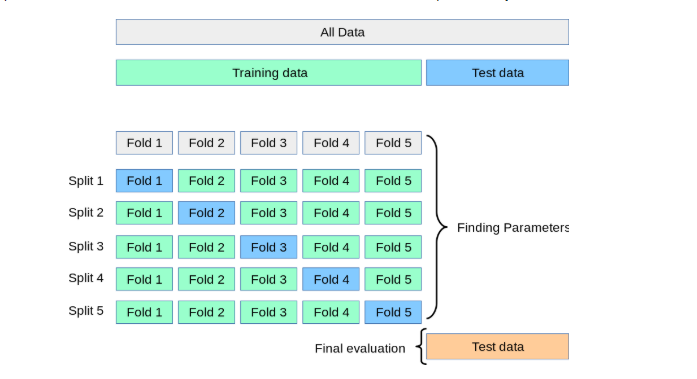

In [0]:
#splitting the data into 10 folds with shuffling
n_fold = 10
folds = KFold(n_splits = n_fold, shuffle = True, random_state = 42)

* **Building the function for model training**

In [0]:
for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
  print(fold_n, train_index, valid_index)

0 [   1    2    3 ... 2997 2998 2999] [   0   14   30   32   44   45   51   52   63   67   80   88   93  102
  124  139  141  144  152  162  174  175  177  178  184  192  194  196
  203  211  246  251  254  256  266  270  289  291  296  298  314  321
  322  331  354  368  393  402  408  414  416  423  436  443  450  457
  463  471  472  478  479  486  495  506  511  521  532  533  535  555
  567  568  598  605  612  644  685  695  718  727  741  746  755  761
  765  772  781  783  787  794  798  817  842  844  845  857  862  879
  881  900  912  927  929  942  965  978  998 1001 1005 1025 1027 1034
 1044 1057 1064 1073 1078 1084 1090 1094 1103 1106 1117 1123 1174 1190
 1195 1200 1211 1222 1226 1231 1241 1261 1263 1268 1269 1270 1272 1298
 1299 1316 1321 1330 1359 1360 1362 1364 1374 1393 1411 1412 1429 1442
 1491 1502 1547 1551 1556 1567 1582 1583 1586 1600 1607 1614 1641 1665
 1670 1691 1694 1706 1710 1725 1732 1746 1752 1760 1762 1763 1770 1793
 1798 1801 1804 1814 1817 1820 1830 183

In [0]:
X_test.shape[0]

4398

In [0]:
import time
from sklearn.metrics import mean_squared_error

**Important Note:** <br>
* Instead of training the model on whole data and predicting on test data, we use below and averaging the final predicts.<br>
The process we follow in the below function is given below.
* We are using K-Fold validation method during training and testing of the data.
* For example if folds = 10 we divide the entire dataset (X) into 10 folds.
* In each fold, **1-piece** acts as validation set and other **9-pieces** act as training set.
* Steps on what happens on each fold:
  * Split the data into train and CV.
  * Train the model on 9-Folds
  * Predict on the rest 1-Fold and save the predictions in **'oof'** array where predictions are stores against each valdiation fold data.
  * Predict on whole test data with the same trained model and store the predictions in **'prediction'** variable.
  * Compute the evaluation metric on **(y_true_fold, y_pred_fold)**
* After all the folds are processed
  * final predictions on test data = predictions/no. of folds
  * final metric on CV = scores/no. of folds or mean(scores)
* Finding the weights of first 50 important features.
* Returning CV **predictions**, **test predictions** and **feature importance df**.

In [0]:
def train_model(X, X_test, y, params = None, folds = folds, model_type='lgb', plot_feature_importance = False, model = None):
  
  oof = np.zeros(X.shape[0]) #stores the validation predictions in each fold
  prediction = np.zeros(X_test.shape[0]) # stores the predictions till current fold adding earlier fold's values
  scores = [] #stores the rmse value during each fold
  feature_importance = pd.DataFrame() # stores the feature importance during each fold

  for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
    print('Fold', fold_n, 'started at', time.ctime())

    ##########################

    #To split the data into train and validation from the given X (whole train) dataset
    #for sklearn models and other models
    if model_type == 'sklearn':
      X_train, X_valid = X[train_index], X[valid_index]
    else:
      X_train, X_valid = X.values[train_index], X.values[valid_index]
    
    #Splitting the data for output variable is commmon for all models
    y_train, y_valid = y[train_index], y[valid_index]

    ##########################

    #Training the models and predictions using valid and test points
    if model_type == 'lgb':
      model = lgb.LGBMRegressor(**params, n_estimators= 20000, nthread = 4, n_jobs = -1)
      model.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_valid, y_valid)],
                eval_metric='rmse',
                verbose = 1000, early_stopping_rounds=200)
      y_pred_valid = model.predict(X_valid)
      y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
    
    if model_type == 'xgb':
      train_data = xgb.DMatrix(data = X_train, label = y_train)
      valid_data = xgb.DMatrix(data = X_valid, label = y_valid)
      watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]

      model = xgb.train(dtrain = train_data, num_boost_round = 20000, evals = watchlist,
                        early_stopping_rounds = 200, verbose_eval = 500, params = params)
      
      y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit = model.best_ntree_limit)
      y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit = model.best_ntree_limit)
    
    if model_type == 'sklearn' :
      model = model
      model.fit(X_train, y_train)
      y_pred_valid = model.predict(X_valid).reshape(-1,)
      score = mean_squared_error(y_valid, y_pred_valid)

      y_pred = model.predict(X_test)
    
    if model_type =='cat':
      model = CatBoostRegressor(iterations = 20000, eval_metric = 'RMSE', **params)
      model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[],
                use_best_model = True, verbose = False)
      
      y_pred_valid = model.predict(X_valid)
      y_pred = model.predict(X_test)
    
    ########################

    #storing the validation predictions for each split in oof
    oof[valid_index] = y_pred_valid.reshape(-1,)
    #storing rmse scores of validation predictions in scores
    scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)

    #adding the test predictions in each split in prediction
    prediction += y_pred

    ########################

    #getting the feature importance scores for each fold

    if model_type == 'lgb':
      fold_importance = pd.DataFrame()
      fold_importance['feature'] = X.columns
      fold_importance['importance'] = model.feature_importances_
      fold_importance['fold'] = fold_n + 1
      feature_importance = pd.concat([feature_importance, fold_importance], axis = 0)

  #averaging the predictions by no. of folds
  prediction /=n_fold

  #for each fold we get the rmse score and avgng it to get the mean cv score
  print('\nCV mean score : {0:.4f}, std: {1:.4f}.\n'.format(np.mean(scores), np.std(scores)))

  if model_type == 'lgb':
    feature_importance['importance'] /= n_fold
    if plot_feature_importance:
      cols = feature_importance[['feature', 'importance']].groupby('feature').mean().sort_values(by = 'importance', ascending = False)[:50].index
      
      best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

      plt.figure(figsize = (16, 12))
      sns.barplot(x = 'importance', y = 'feature', data = best_features.sort_values(by = 'importance', ascending = False))
      plt.title('LGB Features (avg over folds) (Top 50 features)')

      return oof, prediction, feature_importance
    return oof, prediction
  
  else:
    return oof, prediction


Fold 0 started at Thu Jun  4 07:09:59 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[383]	training's rmse: 1.61861	valid_1's rmse: 2.11192
Fold 1 started at Thu Jun  4 07:10:01 2020
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.38525	valid_1's rmse: 1.83776
Early stopping, best iteration is:
[1223]	training's rmse: 1.31486	valid_1's rmse: 1.83548
Fold 2 started at Thu Jun  4 07:10:04 2020
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.37539	valid_1's rmse: 1.88337
Early stopping, best iteration is:
[901]	training's rmse: 1.40877	valid_1's rmse: 1.87882
Fold 3 started at Thu Jun  4 07:10:07 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[793]	training's rmse: 1.45371	valid_1's rmse: 1.92249
Fold 4 started at Thu Jun  4 07:10:10 2020
Training until validation scores don't improve for 200 round

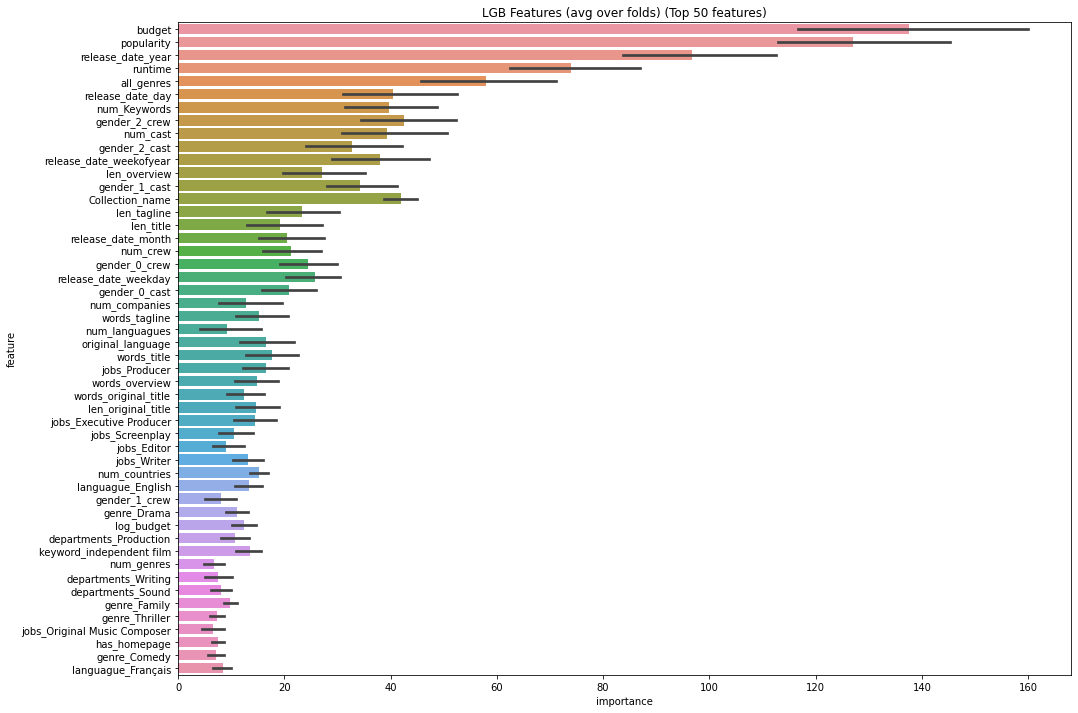

In [0]:
params = {'num_leaves' : 30,
          'min_data_in_leaf':10,
          'objective': 'regression',
          'max_depth': 5,
          'learning_rate': 0.01,
          'boosting': 'gbdt',
          'feature_fraction':0.9,
          'bagging_speed':11,
          'metric':'rmse',
          'lambda_l1': 0.2,
          'verbosity': -1}

oof_lgb, prediction_lgb, feature_imp = train_model(X, X_test, y, params = params, model_type = 'lgb', plot_feature_importance = True)

* We see from above that budget, popularity and release_date_year are the most important features for predicting revenue of a film.
* Lets have a look at train_model function output.

In [0]:
oof_lgb

array([17.85879707, 18.73551921, 16.95306969, ..., 18.42661611,
       18.4640806 , 17.9262917 ])

In [0]:
prediction_lgb

array([15.22426723, 14.8554782 , 15.5902429 , ..., 17.53323635,
       14.85278457, 13.3118864 ])

In [0]:
y

0       16.326300
1       18.370959
2       16.387512
3       16.588099
4       15.182615
          ...    
2995    14.283442
2996    12.103990
2997    18.309266
2998    18.962792
2999    18.223292
Name: revenue, Length: 3000, dtype: float64

In [0]:
feature_imp

,feature,importance,fold
0,budget,89.4,1
1,original_language,6.3,1
2,popularity,106.8,1
3,runtime,52.1,1
4,Collection_name,33.5,1
...,...,...,...
236,words_tagline,10.9,10
237,len_overview,12.9,10
238,words_overview,10.4,10
239,len_original_title,11.2,10


**OOF Features based on texts**

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeCV

In [0]:
train_texts.columns

Index(['title', 'tagline', 'overview', 'original_title'], dtype='object')

Over below what we are doing is :
* Taking the text columns such as 'overview', 'title', 'tagline' etc and converting these into numerical vectors using nlp methods by working on each column.
* We input the **train_texts (vector of text column)**, **test_texts**, **output variable(y)** to the function **'train_model"**.
* Training the model on **text_vectors** and **output variable (y)**.
* Cross validating and testing on CV fold and **test_texts**.
* Making the CV predictions as respective text column vectors in train data set.
* Making the test predictions as respective text column vectors in test data set.
* So, overall we'll be having few new features in other words we'll be having **predictions itself as features.**

We discussed what below cell does but wy we are doing it?
<br>
* Till now we used text feature column as ....
* To actually use these columns in features one way is
  * To change the text into vector using Tfidf or any other nlp method and use those vector components as features.
  * But this will add huge amount of features. How can we avoid this?
* To avoid huge features, created a meta-feature by training model only on tf-idf vector.
* As a final output we got columns with predicted values of revenue based on texts and added this column to normal data.

In [0]:
for col in train_texts.columns:
  print('process started for columns : ', col)
  vectorizer = TfidfVectorizer(
      sublinear_tf = True,
      analyzer = 'word',
      token_pattern = r'\w{1,}',
      ngram_range = (1,2),
      min_df = 10
  )
  vectorizer.fit(list(train_texts[col].fillna('')) + list(test_texts[col].fillna('')))
  
  train_col_text = vectorizer.transform(train_texts[col].fillna(''))
  test_col_text = vectorizer.transform(test_texts[col].fillna(''))

  model = RidgeCV(alphas = (0.01, 0.1, 1.0, 10, 100), scoring = 'neg_mean_squared_error', cv = folds)

  oof_text, prediction_text = train_model(train_col_text, test_col_text, y, params=None, model_type = 'sklearn', model = model)

  X[col + '_oof'] = oof_text
  X_test[col + '_oof'] = prediction_text

process started for columns :  title
Fold 0 started at Thu Jun  4 07:10:27 2020
Fold 1 started at Thu Jun  4 07:10:28 2020
Fold 2 started at Thu Jun  4 07:10:28 2020
Fold 3 started at Thu Jun  4 07:10:29 2020
Fold 4 started at Thu Jun  4 07:10:29 2020
Fold 5 started at Thu Jun  4 07:10:29 2020
Fold 6 started at Thu Jun  4 07:10:30 2020
Fold 7 started at Thu Jun  4 07:10:30 2020
Fold 8 started at Thu Jun  4 07:10:31 2020
Fold 9 started at Thu Jun  4 07:10:31 2020

CV mean score : 3.0381, std: 0.2022.

process started for columns :  tagline
Fold 0 started at Thu Jun  4 07:10:32 2020
Fold 1 started at Thu Jun  4 07:10:32 2020
Fold 2 started at Thu Jun  4 07:10:33 2020
Fold 3 started at Thu Jun  4 07:10:33 2020
Fold 4 started at Thu Jun  4 07:10:34 2020
Fold 5 started at Thu Jun  4 07:10:34 2020
Fold 6 started at Thu Jun  4 07:10:35 2020
Fold 7 started at Thu Jun  4 07:10:35 2020
Fold 8 started at Thu Jun  4 07:10:36 2020
Fold 9 started at Thu Jun  4 07:10:37 2020

CV mean score : 2.9604, 

In [0]:
y

0       16.326300
1       18.370959
2       16.387512
3       16.588099
4       15.182615
          ...    
2995    14.283442
2996    12.103990
2997    18.309266
2998    18.962792
2999    18.223292
Name: revenue, Length: 3000, dtype: float64

* Below are nothing but the predictions based on text vectors.

In [0]:
X[['title_oof','tagline_oof', 'overview_oof', 'original_title_oof']]

,title_oof,tagline_oof,overview_oof,original_title_oof
0,16.099271,16.417491,16.185750,16.112936
1,16.542766,15.661259,16.095318,17.019501
2,15.906796,16.204841,15.770415,15.806374
3,15.980062,15.335129,15.646831,15.878641
4,14.951660,15.324653,15.597919,15.819620
...,...,...,...,...
2995,15.864111,16.865847,16.180040,15.773236
2996,16.072769,15.282316,15.847308,15.805667
2997,16.144874,16.106048,15.514390,16.117817
2998,15.901422,16.911112,17.541190,15.807218


In [0]:
train_col_text[0]

<1x281 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

##**Additional feaure generation**

* Adding few more features

In [0]:
X.head()

,budget,original_language,popularity,runtime,Collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,...,jobs_Original Music Composer,jobs_Art Direction,jobs_Production Design,jobs_Costume Design,jobs_Writer,jobs_Set Decoration,jobs_Makeup Artist,jobs_Sound Re-Recording Mixer,departments_Production,departments_Sound,departments_Art,departments_Crew,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors,log_budget,has_homepage,release_date_year,release_date_weekday,release_date_month,release_date_weekofyear,release_date_day,release_date_quarter,len_title,words_title,len_tagline,words_tagline,len_overview,words_overview,len_original_title,words_original_title,title_oof,tagline_oof,overview_oof,original_title_oof
0,14000000,10,6.575393,93.0,282,1,1,480,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,...,1,1,1,1,1,1,4,2,9,10,12,4,2,13,8,4,2,4,4,0,16.454568,0,2015,4,2,8,20,1,22,38,52,86,155,243,22,38,16.099271,16.417491,16.185750,16.112936
1,40000000,10,8.248895,113.0,641,1,4,516,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,4,1,0,0,1,0,1,1,1,0,0,0,17.504390,0,2004,4,8,32,6,3,40,59,60,100,393,601,40,59,16.542766,15.661259,16.095318,17.019501
2,3300000,10,64.299990,105.0,0,0,1,658,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,1,1,2,18,9,5,9,1,5,4,3,6,3,1,0,15.009433,1,2014,4,10,41,10,4,8,12,47,78,130,194,8,12,15.906796,16.204841,15.770415,15.806374
3,1200000,16,3.174936,122.0,0,0,2,742,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,13.997833,1,2012,4,3,10,9,1,7,11,0,4,581,900,7,11,15.980062,15.335129,15.646831,15.878641
4,0,24,1.148070,118.0,0,0,2,295,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.000000,0,2009,3,2,6,5,1,10,17,0,4,168,265,4,8,14.951660,15.324653,15.597919,15.819620


**some features from** https://www.kaggle.com/somang1418/happy-valentines-day-and-keep-kaggling-3

In [0]:
def new_features(df):
  
  df['budget_to_popularity'] = df['budget'] / df['popularity']
  df['budget_to_runtime'] = df['budget'] / df['runtime']
  df['_budget_year_ratio'] = df['budget'] / (df['release_date_year']*df['release_date_year'])
  df['_releaseYear_popularity_ratio'] = df['release_date_year'] / df['popularity']
  df['_releaseYear_popularity_ratio2'] = df['popularity'] / df['release_date_year']
  df['runtime_to_mean_year'] = df['runtime'] / df.groupby('release_date_year')['runtime'].transform('mean')
  df['popularity_to_mean_year'] = df['popularity'] /df.groupby('release_date_year')['popularity'].transform('mean')
  df['budget_to_mean_year'] = df['budget'] / df.groupby('release_date_year')['budget'].transform('mean')

  return df

In [0]:
X = new_features(X)
X_test = new_features(X_test)

In [0]:
X.head()

,budget,original_language,popularity,runtime,Collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,...,departments_Production,departments_Sound,departments_Art,departments_Crew,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors,log_budget,has_homepage,release_date_year,release_date_weekday,release_date_month,release_date_weekofyear,release_date_day,release_date_quarter,len_title,words_title,len_tagline,words_tagline,len_overview,words_overview,len_original_title,words_original_title,title_oof,tagline_oof,overview_oof,original_title_oof,budget_to_popularity,budget_to_runtime,_budget_year_ratio,_releaseYear_popularity_ratio,_releaseYear_popularity_ratio2,runtime_to_mean_year,popularity_to_mean_year,budget_to_mean_year
0,14000000,10,6.575393,93.0,282,1,1,480,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,...,9,10,12,4,2,13,8,4,2,4,4,0,16.454568,0,2015,4,2,8,20,1,22,38,52,86,155,243,22,38,16.099271,16.417491,16.185750,16.112936,2.129150e+06,150537.634409,3.448085,306.445562,0.003263,0.830821,0.642915,0.472601
1,40000000,10,8.248895,113.0,641,1,4,516,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,4,1,0,0,1,0,1,1,1,0,0,0,17.504390,0,2004,4,8,32,6,3,40,59,60,100,393,601,40,59,16.542766,15.661259,16.095318,17.019501,4.849134e+06,353982.300885,9.960120,242.941630,0.004116,1.075080,0.984041,1.237933
2,3300000,10,64.299990,105.0,0,0,1,658,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,18,9,5,9,1,5,4,3,6,3,1,0,15.009433,1,2014,4,10,41,10,4,8,12,47,78,130,194,8,12,15.906796,16.204841,15.770415,15.806374,5.132194e+04,31428.571429,0.813570,31.321933,0.031927,0.996067,6.073148,0.141137
3,1200000,16,3.174936,122.0,0,0,2,742,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0,0,0,13.997833,1,2012,4,3,10,9,1,7,11,0,4,581,900,7,11,15.980062,15.335129,15.646831,15.878641,3.779604e+05,9836.065574,0.296432,633.713561,0.001578,1.151552,0.387724,0.043295
4,0,24,1.148070,118.0,0,0,2,295,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0.000000,0,2009,3,2,6,5,1,10,17,0,4,168,265,4,8,14.951660,15.324653,15.597919,15.819620,0.000000e+00,0.000000,0.000000,1749.893299,0.000571,1.107001,0.145631,0.000000


In [0]:
X_test.head()

,budget,original_language,popularity,runtime,Collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,...,departments_Production,departments_Sound,departments_Art,departments_Crew,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors,log_budget,has_homepage,release_date_year,release_date_weekday,release_date_month,release_date_weekofyear,release_date_day,release_date_quarter,len_title,words_title,len_tagline,words_tagline,len_overview,words_overview,len_original_title,words_original_title,title_oof,tagline_oof,overview_oof,original_title_oof,budget_to_popularity,budget_to_runtime,_budget_year_ratio,_releaseYear_popularity_ratio,_releaseYear_popularity_ratio2,runtime_to_mean_year,popularity_to_mean_year,budget_to_mean_year
0,0,21,3.851534,90.0,420,1,4,320,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0.000000,1,2007,5,7,28,14,3,28,44,51,79,335,507,18,22,16.321322,16.364458,15.726476,15.808897,0.000000,0.000000,0.000000,521.091077,0.001919,0.833031,0.480846,0.000000
1,88000,10,3.559789,65.0,0,0,2,789,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,1,0,0,1,1,1,1,1,0,0,0,11.385103,0,1958,0,5,21,19,2,27,46,96,145,162,250,27,46,16.809644,14.981165,16.629307,16.882092,24720.566303,1353.846154,0.022954,550.032600,0.001818,0.587703,0.387141,0.035495
2,0,10,8.085194,100.0,0,0,2,589,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,2,1,1,1,0,1,1,1,0,0,0,0.000000,0,1997,4,5,21,23,2,16,26,41,66,362,546,16,26,15.567818,15.373363,15.709572,15.985555,0.000000,0.000000,0.000000,246.994692,0.004049,0.913637,1.202000,0.000000
3,6800000,14,8.596012,130.0,0,0,3,733,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,13,14,6,9,3,7,3,2,3,6,3,0,15.732433,1,2010,5,9,35,4,3,9,13,55,86,302,453,9,13,15.901059,16.429695,15.290713,15.808897,791064.507588,52307.692308,1.683127,233.829362,0.004277,1.256376,1.114299,0.221289
4,2000000,10,3.217680,92.0,0,0,2,651,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5,1,0,0,2,0,2,2,2,0,0,0,14.508658,0,2005,4,2,6,11,1,18,28,221,348,894,1330,18,28,15.523005,16.728335,15.838348,15.808897,621565.848686,21739.130435,0.497509,623.119763,0.001605,0.884740,0.436585,0.077771


* Training and testing the model again with dataset along with new features.
* Lets see if new columns improves CV score or not.

Fold 0 started at Thu Jun  4 07:10:53 2020
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.26238	valid_1's rmse: 2.04607
[2000]	training's rmse: 0.950588	valid_1's rmse: 2.02967
Early stopping, best iteration is:
[2779]	training's rmse: 0.788092	valid_1's rmse: 2.0264
Fold 1 started at Thu Jun  4 07:11:04 2020
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.32115	valid_1's rmse: 1.85795
Early stopping, best iteration is:
[1066]	training's rmse: 1.29694	valid_1's rmse: 1.85409
Fold 2 started at Thu Jun  4 07:11:08 2020
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.2924	valid_1's rmse: 1.93563
[2000]	training's rmse: 0.987294	valid_1's rmse: 1.90331
Early stopping, best iteration is:
[2091]	training's rmse: 0.963573	valid_1's rmse: 1.90073
Fold 3 started at Thu Jun  4 07:11:16 2020
Training until validation scores don't improve for 200 rounds.
[1000]	training's rms

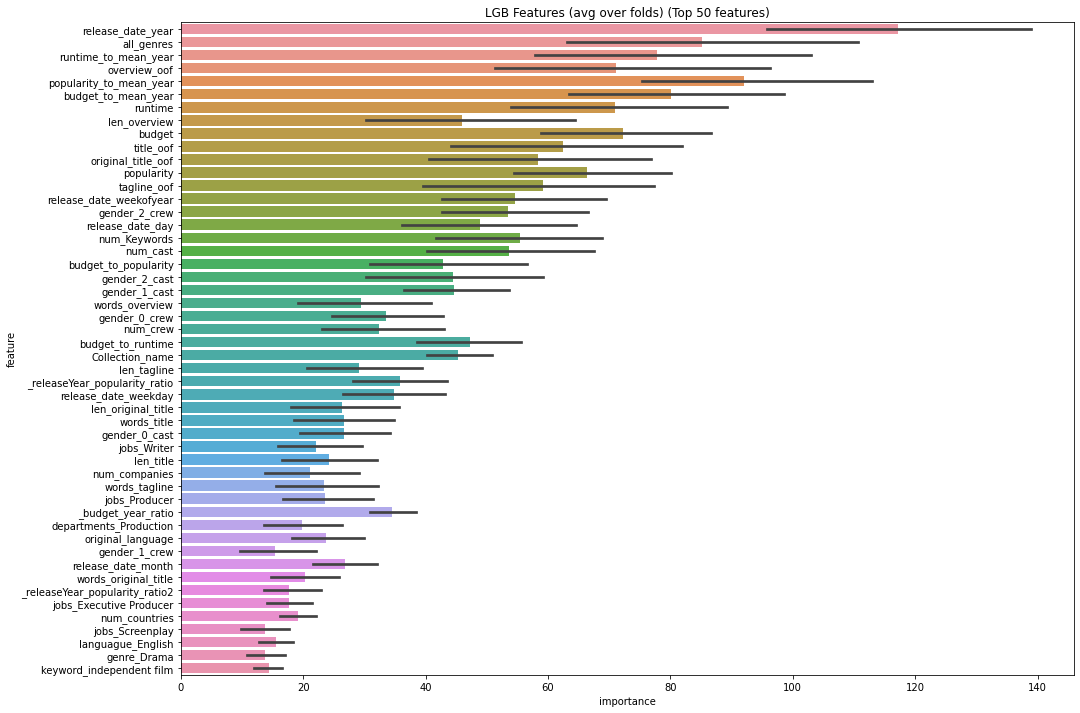

In [0]:
oof_lgb, prediction_lgb, feature_imp = train_model(X, X_test, y, params = params, model_type = 'lgb', plot_feature_importance = True)

* Earlier without all these new features CV mean score is **2.0788** where as with new features **2.0666**.
* There's some improvement in **rmse** but don't know how to quantify this change.
* If you can see top important features also got changed.
* Still there's some adjustment needs to be done for output variable or revenue is pending.

#**Important features**

* Let's have a look at important features using ELI5 and SHAP!
* We are again training the model on data and finding the important features using **eli5**.
* **LGBMRegressor** also has inbuilt function **feature_importances_** which shows feature and its corresponding weight.
* But we check weights of features using **eli5**.
* **Training the model on whole dataset.**

**Training the model**

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1)

params = {'num_leaves': 30,
          'min_data_in_leaf': 20,
          'objective': 'regression',
          'max_depth': 6,
          'learning_rate': 0.01,
          'boosting': 'gbdt',
          'feature_fraction': 0.9,
          'bagging_freq': 1,
          'bagging_fraction': 0.9,
          'bagging_seed': 11,
          'metric': 'rmse',
          'lambda_l1': 0.2,
          'verbosity': -1}
model_1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model_1.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
             eval_metric='rmse', verbose = 1000, early_stopping_rounds = 200)

eli5.show_weights(model_1, feature_filter=lambda x: x!='<BIAS>')

Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.17664	valid_1's rmse: 2.10523
Early stopping, best iteration is:
[1382]	training's rmse: 1.02114	valid_1's rmse: 2.099


Weight,Feature
0.2392,_budget_year_ratio
0.0896,popularity_to_mean_year
0.0784,budget_to_mean_year
0.0569,budget
0.0505,release_date_year
0.0304,popularity
0.0240,budget_to_runtime
0.0238,all_genres
0.0195,runtime
0.0189,runtime_to_mean_year


* We can see that important features native to LGB and top features in eli5 are mostly similar.
* This means that our model is quite good at working with these features.

**Checking the same using shap**

In [0]:
!pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394114 sha256=353d696515aaeaa5a8988880152e45e547955478717e59b12087e1da88d56a25
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [0]:
import shap

Passing 2700 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.
100%|===================| 2699/2700 [90:39<00:02]       

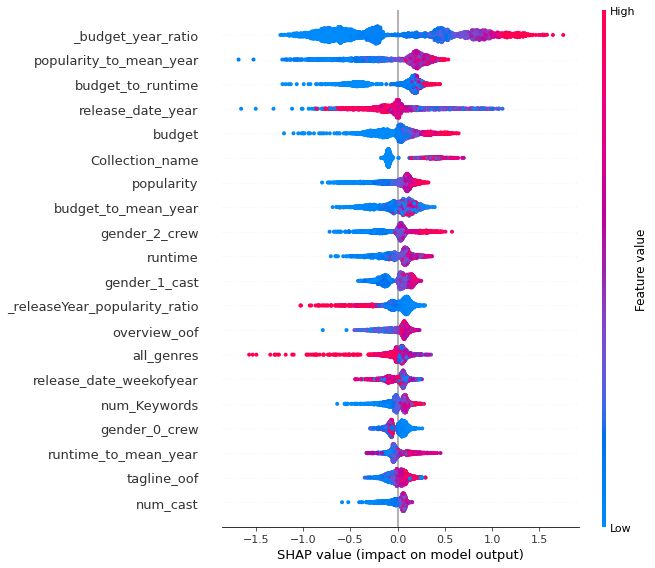

In [0]:
explainer = shap.TreeExplainer(model_1, X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

* SHAP provides more detailed information even if it my be more difficult to understand.
* For example low budget has negative impact on revenue, while high values usually tend to have high revenue.

invalid value encountered in subtract


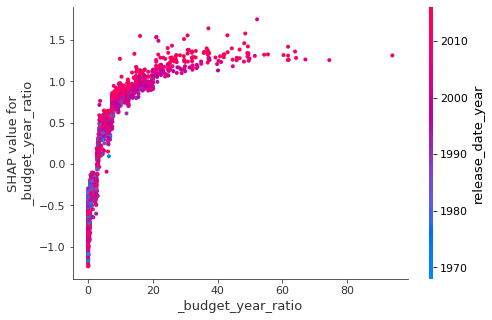

invalid value encountered in subtract


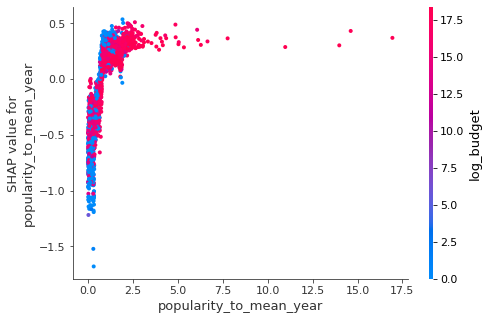

invalid value encountered in subtract


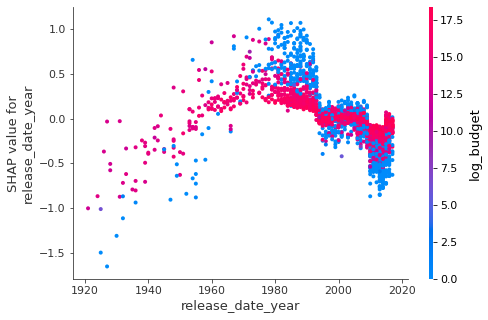

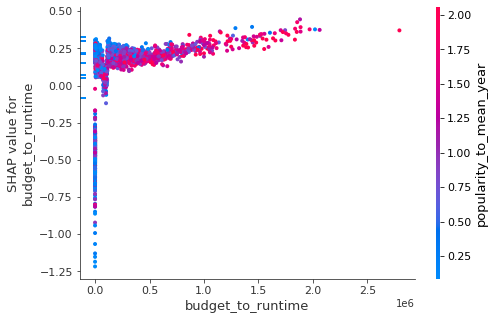

invalid value encountered in subtract


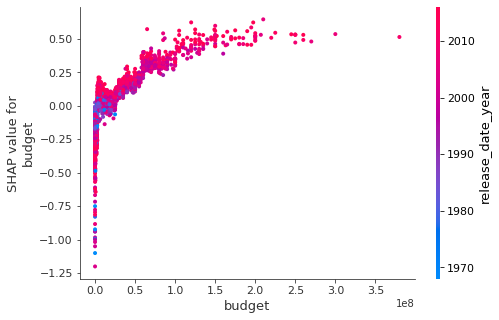

invalid value encountered in subtract


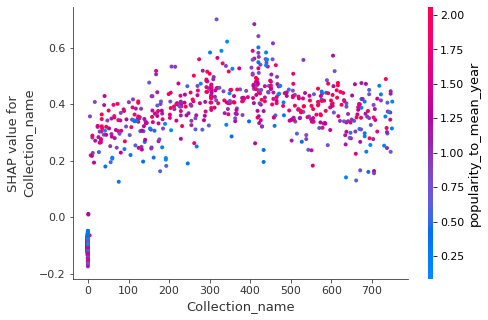

invalid value encountered in subtract


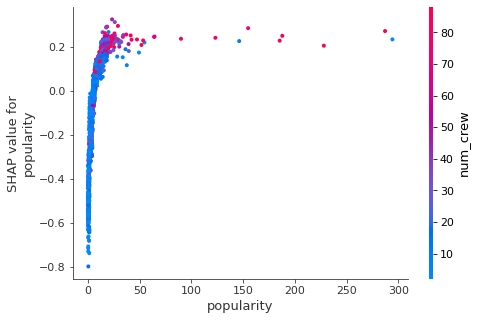

invalid value encountered in subtract


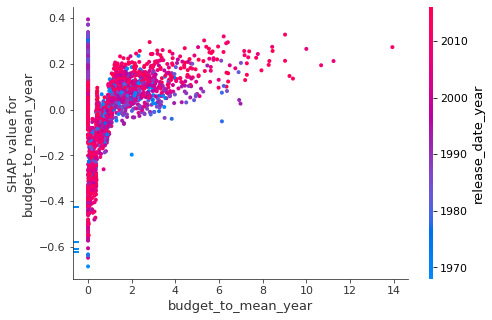

invalid value encountered in subtract


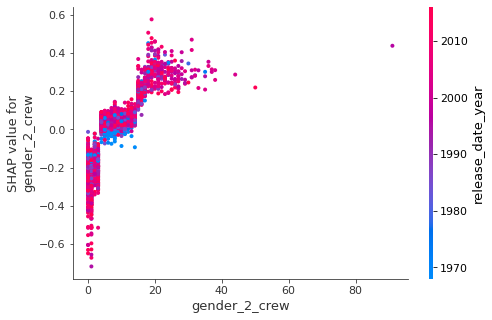

invalid value encountered in subtract


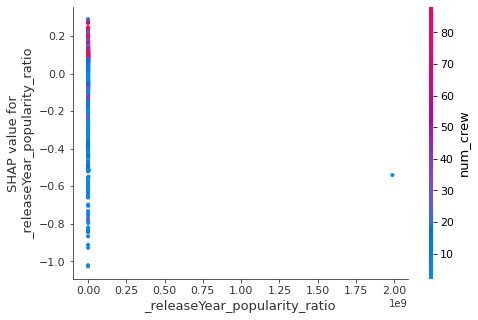

In [0]:
top_cols = X_train.columns[np.argsort(shap_values.std(0))[::-1]][:10]

for col in top_cols:
  shap.dependence_plot(col, shap_values, X_train)

* Here we can see interactions between important features.
* There are some interesting things here for example relationship between **release_date_year** and **log_budget**.
* Upto ~1990 low budget films brought higher revenues, but after 2000 year high budgets tended to be correlated with higher revenues.
* And in general the effect of budget diminished.
* Let's create new features as **intetrfactions between top important features**.
* Some of them make little sense, but maybe they could improve the model.

#**External Features**

In [0]:
def top_cols_interaction(df):
  df['budget_to_year'] = df['budget'] / df['release_date_year']
  df['budget_to_mean_year_to_year'] = df['budget_to_mean_year'] / df['release_date_year']
  df['popularity_to_mean_year_to_log_budget'] = df['popularity_to_mean_year'] / df['log_budget']
  df['year_to_log_budget'] = df['release_date_year'] / df['log_budget']
  df['budget_to_runtime_to_year'] = df['budget_to_runtime'] / df['release_date_year']
  df['gender_1_cast_to_log_budget'] = df['gender_1_cast'] / df['log_budget']
  df['all_genres_to_popularity_to_mean_year'] = df['all_genres'] / df['popularity_to_mean_year']
  df['genders_2_crew_to_budget_to_mean_year'] = df['gender_2_crew'] / df['budget_to_mean_year']
  df['overview_oof_to_genders_2_crew'] = df['overview_oof'] / df['gender_2_crew']

  return df

In [0]:
X = top_cols_interaction(X)
X_test = top_cols_interaction(X_test)

In [0]:
X = X.replace([np.inf, -np.inf], 0).fillna(0)

X_test = X_test.replace([np.inf, -np.inf], 0).fillna(0)

In [0]:
X.head(2)

,budget,original_language,popularity,runtime,Collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,...,departments_Visual Effects,departments_Lighting,departments_Actors,log_budget,has_homepage,release_date_year,release_date_weekday,release_date_month,release_date_weekofyear,release_date_day,release_date_quarter,len_title,words_title,len_tagline,words_tagline,len_overview,words_overview,len_original_title,words_original_title,title_oof,tagline_oof,overview_oof,original_title_oof,budget_to_popularity,budget_to_runtime,_budget_year_ratio,_releaseYear_popularity_ratio,_releaseYear_popularity_ratio2,runtime_to_mean_year,popularity_to_mean_year,budget_to_mean_year,budget_to_year,budget_to_mean_year_to_year,popularity_to_mean_year_to_log_budget,year_to_log_budget,budget_to_runtime_to_year,gender_1_cast_to_log_budget,all_genres_to_popularity_to_mean_year,genders_2_crew_to_budget_to_mean_year,overview_oof_to_genders_2_crew
0,14000000,10,6.575393,93.0,282,1,1,480,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,...,4,4,0,16.454568,0,2015,4,2,8,20,1,22,38,52,86,155,243,22,38,16.099271,16.417491,16.185750,16.112936,2.129150e+06,150537.634409,3.448085,306.445562,0.003263,0.830821,0.642915,0.472601,6947.890819,0.000235,0.039072,122.458396,74.708503,0.486187,746.599175,27.507326,1.245058
1,40000000,10,8.248895,113.0,641,1,4,516,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,17.504390,0,2004,4,8,32,6,3,40,59,60,100,393,601,40,59,16.542766,15.661259,16.095318,17.019501,4.849134e+06,353982.300885,9.960120,242.941630,0.004116,1.075080,0.984041,1.237933,19960.079840,0.000618,0.056217,114.485566,176.637875,0.571285,524.368431,3.231194,4.023830


In [0]:
X_test.head(2)

,budget,original_language,popularity,runtime,Collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,...,departments_Visual Effects,departments_Lighting,departments_Actors,log_budget,has_homepage,release_date_year,release_date_weekday,release_date_month,release_date_weekofyear,release_date_day,release_date_quarter,len_title,words_title,len_tagline,words_tagline,len_overview,words_overview,len_original_title,words_original_title,title_oof,tagline_oof,overview_oof,original_title_oof,budget_to_popularity,budget_to_runtime,_budget_year_ratio,_releaseYear_popularity_ratio,_releaseYear_popularity_ratio2,runtime_to_mean_year,popularity_to_mean_year,budget_to_mean_year,budget_to_year,budget_to_mean_year_to_year,popularity_to_mean_year_to_log_budget,year_to_log_budget,budget_to_runtime_to_year,gender_1_cast_to_log_budget,all_genres_to_popularity_to_mean_year,genders_2_crew_to_budget_to_mean_year,overview_oof_to_genders_2_crew
0,0,21,3.851534,90.0,420,1,4,320,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.000000,1,2007,5,7,28,14,3,28,44,51,79,335,507,18,22,16.321322,16.364458,15.726476,15.808897,0.000000,0.000000,0.000000,521.091077,0.001919,0.833031,0.480846,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,665.493973,0.000000,15.726476
1,88000,10,3.559789,65.0,0,0,2,789,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,11.385103,0,1958,0,5,21,19,2,27,46,96,145,162,250,27,46,16.809644,14.981165,16.629307,16.882092,24720.566303,1353.846154,0.022954,550.032600,0.001818,0.587703,0.387141,0.035495,44.94382,0.000018,0.034004,171.979114,0.691443,0.175668,2038.015595,169.036364,2.771551


**<h4>Adding some external features**

https://www.kaggle.com/kamalchhirang/eda-feature-engineering-lgb-xgb-cat

* We are adding some additional features such as **popularity2**, **rating**, **totalVotes**.
* We don't know the source of this dataset, but as this is Kudos competition, we are adding this data.
* Otherwise we only use the data what we are given in the problem and we generate numerical features from the given features iteself.
* Merging the additional features to our training and testing dataset on 'imdb_id'.
* This column is already dropped so we are adding it again from the original dataset.
* Keep in mind that throughout our process we didn't change the order of the rows.

**Reading additional features**

In [0]:
#listing the names of files in tmdb-additional-features.zip
for names in ZipFile('/content/tmdb-additional-features.zip').namelist():
  print(names)

TestAdditionalFeatures.csv
TrainAdditionalFeatures.csv


In [0]:
#Reading the sample_submission.csv from zipfile
with ZipFile('/content/tmdb-additional-features.zip') as zip:
  train_add_feats = pd.read_csv(zip.open('TrainAdditionalFeatures.csv'))
  test_add_feats = pd.read_csv(zip.open('TestAdditionalFeatures.csv'))

In [0]:
train_add_feats.head(5)

,imdb_id,popularity2,rating,totalVotes
0,tt0169547,16.217,8.0,6016.0
1,tt0119116,26.326,7.4,5862.0
2,tt0325980,28.244,7.7,11546.0
3,tt0266697,18.202,7.9,8638.0
4,tt0418763,9.653,6.6,1201.0


In [0]:
test_add_feats.head()

,imdb_id,popularity2,rating,totalVotes
0,tt0113101,11.182,6.3,1078.0
1,tt0107286,8.038,6.5,111.0
2,tt0076759,36.016,8.2,10729.0
3,tt0266543,18.503,7.8,10766.0
4,tt0033467,15.322,8.1,2203.0


In [0]:
train_add_feats.isnull().sum()

imdb_id        0
popularity2    5
rating         5
totalVotes     5
dtype: int64

* Merging the feats data with X, X_test on imdb_id and again dropping the 'imdb_id' column.

In [0]:
X['imdb_id'] = train['imdb_id']
X_test['imdb_id'] = test['imdb_id']

X = pd.merge(X, train_add_feats, how='left', on = ['imdb_id'])
X_test = pd.merge(X_test, test_add_feats, how = 'left', on = ['imdb_id'])

X = X.drop(['imdb_id'], axis = 1)
X_test = X_test.drop(['imdb_id'], axis = 1)

In [0]:
X.head(2)

,budget,original_language,popularity,runtime,Collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,...,jobs_Director of Photography,jobs_Original Music Composer,jobs_Art Direction,jobs_Production Design,jobs_Costume Design,jobs_Writer,jobs_Set Decoration,jobs_Makeup Artist,jobs_Sound Re-Recording Mixer,departments_Production,departments_Sound,departments_Art,departments_Crew,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors,log_budget,has_homepage,release_date_year,release_date_weekday,release_date_month,release_date_weekofyear,release_date_day,release_date_quarter,len_title,words_title,len_tagline,words_tagline,len_overview,words_overview,len_original_title,words_original_title,popularity2,rating,totalVotes
0,14000000,10,6.575393,93.0,282,1,1,480,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,...,1,1,1,1,1,1,1,4,2,9,10,12,4,2,13,8,4,2,4,4,0,16.454568,0,2015,4,2,8,20,1,22,38,52,86,155,243,22,38,10.400,5.0,482.0
1,40000000,10,8.248895,113.0,641,1,4,516,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,4,1,0,0,1,0,1,1,1,0,0,0,17.504390,0,2004,4,8,32,6,3,40,59,60,100,393,601,40,59,15.229,6.4,1528.0


In [0]:
X_test.head(2)

,budget,original_language,popularity,runtime,Collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,...,jobs_Director of Photography,jobs_Original Music Composer,jobs_Art Direction,jobs_Production Design,jobs_Costume Design,jobs_Writer,jobs_Set Decoration,jobs_Makeup Artist,jobs_Sound Re-Recording Mixer,departments_Production,departments_Sound,departments_Art,departments_Crew,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors,log_budget,has_homepage,release_date_year,release_date_weekday,release_date_month,release_date_weekofyear,release_date_day,release_date_quarter,len_title,words_title,len_tagline,words_tagline,len_overview,words_overview,len_original_title,words_original_title,popularity2,rating,totalVotes
0,0,21,3.851534,90.0,420,1,4,320,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.000000,1,2007,5,7,28,14,3,28,44,51,79,335,507,18,22,6.468,6.6,91.0
1,88000,10,3.559789,65.0,0,0,2,789,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,1,0,2,1,0,0,1,1,1,1,1,0,0,0,11.385103,0,1958,0,5,21,19,2,27,46,96,145,162,250,27,46,3.649,4.5,51.0


**<h4>Lets see if these three new features improve our results.**

Fold 0 started at Thu Jun  4 09:34:09 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[471]	training's rmse: 1.26636	valid_1's rmse: 2.07109
Fold 1 started at Thu Jun  4 09:34:12 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[738]	training's rmse: 1.08639	valid_1's rmse: 1.8244
Fold 2 started at Thu Jun  4 09:34:17 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[759]	training's rmse: 1.05903	valid_1's rmse: 1.85938
Fold 3 started at Thu Jun  4 09:34:21 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[468]	training's rmse: 1.28408	valid_1's rmse: 1.82716
Fold 4 started at Thu Jun  4 09:34:23 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[789]	training's rmse: 1.02903	valid_1's rmse: 2.141
Fold 5 started at Thu J

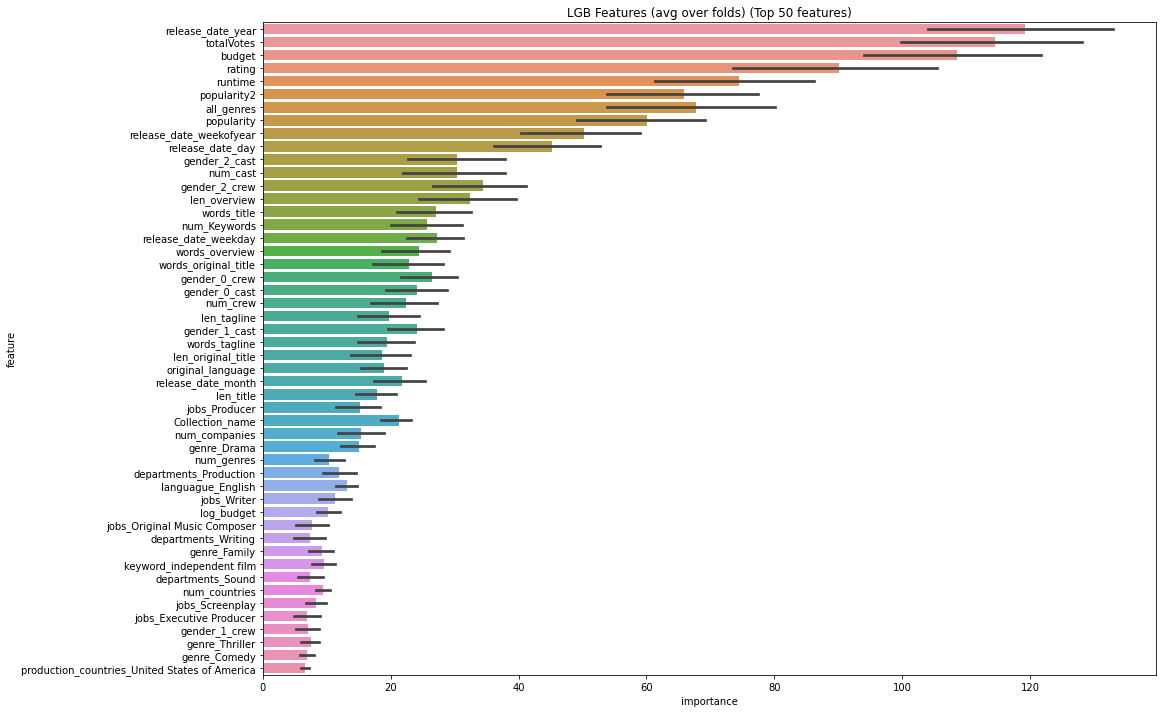

In [0]:
params = {'num_leaves' : 30,
          'min_data_in_leaf' : 20,
          'objective': 'regression',
          'max_depth' : 9,
          'learning_rate': 0.01,
          'boosting': 'gbdt',
          'feature_fraction': 0.9,
          'bagging_freq': 1,
          'bagging_fraction':0.9,
          'bagging_seed': 11,
          'metric': 'rmse',
          'lambda_l1':0.2,
          'verbosity': -1}

oof_lgb, prediction_lgb, feat_imp = train_model(X, X_test, y, params=params, model_type = 'lgb', plot_feature_importance=True)

* See the CV mean rmse after adding some additional features.
* Earlier it was **2.0666** now it reduced to **2.0202**.
* We can see the considerable drop in rmse.

#**Blending**

What is blending?
* Blending is a type of **ensemble model technique** that follow same approach as stacking but uses only a **validation** set from train to make predictions.
* Unlike stacking, the predictions are made on the validation set only.
* Validation set and the predictions are used to build a model which is run on the test set.
* Detailed expalanation is given below:
  * Train set is split into training and validation sets.
  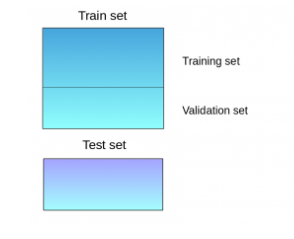
  * Model(s) are fitted on the training set.
  * Predictions are made on the validation set and the test sets.
  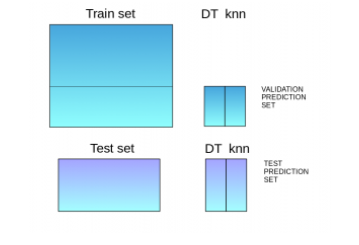
  * The validation set and its predictions are used as features to build a new model.
  * This model is used to make final predictions on the test and meta-features.

##**Implementing XGBoosting**

In [0]:
import xgboost as xgb

In [0]:
xgb_params = {'eta' : 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}

oof_xgb, prediction_xgb = train_model(X, X_test, y, params = xgb_params, model_type = 'xgb', plot_feature_importance = False)

Fold 0 started at Thu Jun  4 09:52:37 2020
[0]	train-rmse:15.5785	valid_data-rmse:15.8737
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.941201	valid_data-rmse:2.06139
[1000]	train-rmse:0.588422	valid_data-rmse:2.04677
[1500]	train-rmse:0.384613	valid_data-rmse:2.0454
Stopping. Best iteration:
[1426]	train-rmse:0.411881	valid_data-rmse:2.04393

Fold 1 started at Thu Jun  4 09:53:22 2020
[0]	train-rmse:15.6066	valid_data-rmse:15.6201
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.943983	valid_data-rmse:1.86228
[1000]	train-rmse:0.597684	valid_data-rmse:1.82756
Stopping. Best iteration:
[1202]	train-rmse:0.501227	valid_data-rmse:1.82421

Fold 2 started at Thu Jun  4 09:54:00 2020
[0]	train-rmse:15.597	valid_data-rmse:15.7094
Multiple ev

* With the external features in data and using **'LGBM'** we got rmse of **2.0202** where now we used **'XGB'** with same data got rmse of **2.0294**.
* Which we can conclude **RMSE(LGBM)<RMSE(XGB)**.

##**CatBoostRegressor**

In [0]:
!pip install catboost

     |████████████████████████████████| 64.8MB 60kB/s 


In [0]:
from catboost import CatBoostRegressor

In [0]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              #'bootstrap_type' : 'Bernouli',
              'colsample_bylevel' : 0.8,
              'bagging_temperature' : 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}

oof_cat, prediction_cat = train_model(X, X_test, y, params = cat_params, model_type = 'cat')

Fold 0 started at Thu Jun  4 12:25:10 2020
Fold 1 started at Thu Jun  4 12:25:56 2020
Fold 2 started at Thu Jun  4 12:26:58 2020
Fold 3 started at Thu Jun  4 12:28:38 2020
Fold 4 started at Thu Jun  4 12:29:51 2020
Fold 5 started at Thu Jun  4 12:31:23 2020
Fold 6 started at Thu Jun  4 12:32:54 2020
Fold 7 started at Thu Jun  4 12:33:49 2020
Fold 8 started at Thu Jun  4 12:35:09 2020
Fold 9 started at Thu Jun  4 12:36:00 2020

CV mean score : 1.9673, std: 0.1717.



##**LGBM**

**with max_depth = 5**

In [0]:
params = {'num_leaves': 30,
          'min_data_in_leaf': 20,
          'objective': 'regression',
          'max_depth': 5,
          'learning_rate': 0.01,
          'boosting': 'gbdt',
          'feature_fraction': 0.9,
          'bagging_freq': 1,
          'bagging_fraction': 0.9,
          'bagging_seed': 11,
          'metric': 'rmse',
          'lambda_l1': 0.2,
          'vebosity': -1}

oof_lgb_1, prediction_lgb_1 = train_model(X, X_test, y, params = params, model_type = 'lgb', plot_feature_importance = False)

Fold 0 started at Thu Jun  4 12:36:44 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[345]	training's rmse: 1.62489	valid_1's rmse: 2.06409
Fold 1 started at Thu Jun  4 12:36:45 2020
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.32387	valid_1's rmse: 1.82579
Early stopping, best iteration is:
[1143]	training's rmse: 1.2708	valid_1's rmse: 1.82103
Fold 2 started at Thu Jun  4 12:36:49 2020
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.32755	valid_1's rmse: 1.83377
Early stopping, best iteration is:
[879]	training's rmse: 1.37866	valid_1's rmse: 1.83045
Fold 3 started at Thu Jun  4 12:36:52 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 1.49426	valid_1's rmse: 1.82275
Fold 4 started at Thu Jun  4 12:36:54 2020
Training until validation scores don't improve for 200 rounds

* Earlier when **max_depth = 9** rmse was **2.0204**, now for **max_depth = 5** score got improved bit **2.0071**.
* But thats okay because boosting technique itself is such a way that **trees are trained with shallow depths**.

**with most of the parameters changed than previous**

In [0]:
params = {'num_leaves': 30,
          'min_data_in_leaf': 20,
          'objective': 'regression',
          'max_depth': 7,
          'learning_rate': 0.02,
          'boosting': 'gbdt',
          'feature_fraction': 0.7,
          'bagging_freq': 5,
          'bagging_fraction': 0.7,
          'bagging_seed': 11,
          'metric': 'rmse',
          'lambda_l1': 0.2,
          'vebosity': -1}

oof_lgb_2, prediction_lgb_2 = train_model(X, X_test, y, params = params, model_type = 'lgb', plot_feature_importance = False)

Fold 0 started at Thu Jun  4 12:50:11 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[304]	training's rmse: 1.31284	valid_1's rmse: 2.05679
Fold 1 started at Thu Jun  4 12:50:13 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[222]	training's rmse: 1.47166	valid_1's rmse: 1.86226
Fold 2 started at Thu Jun  4 12:50:14 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[451]	training's rmse: 1.14818	valid_1's rmse: 1.85134
Fold 3 started at Thu Jun  4 12:50:16 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[290]	training's rmse: 1.34255	valid_1's rmse: 1.81441
Fold 4 started at Thu Jun  4 12:50:17 2020
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.691624	valid_1's rmse: 2.11246
Early stopping, best iteration is:
[819]	training's r

* Mean rmse CV improved much better : 
  * Earlier : **2.0071**
  * Now : **2.0100**
* We now have CV predictions and predictions on text with us from three models:
  * **XGB**
  * **CAT**
  * **LGBM1**
  * **LGBM2**
* We use all the above results in stacking.

#**Staking**

lgb (with max_depth : 9)
<br>lgb_1 (with max_depth : 5)
<br>lgb_2 (with max_depth : 7)

**Stacking all the train predictions and predictions on test data**

In [0]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2]).transpose()
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_cat, prediction_lgb_1, prediction_lgb_2]).transpose()

#making the dataframes
train_stack = pd.DataFrame(train_stack, columns = ['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2'])
test_stack = pd.DataFrame(test_stack, columns = ['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2'])

In [0]:
train_stack.head(2)

,lgb,xgb,cat,lgb_1,lgb_2
0,17.659247,17.738022,17.190411,17.647928,17.647928
1,18.454523,19.457306,19.309802,18.524386,18.524386


In [0]:
test_stack.head(2)

,lgb,xgb,cat,lgb_1,lgb_2
0,15.943538,16.417067,15.204639,15.602989,15.602989
1,13.844654,14.004107,13.976825,13.388290,13.388290


**Using the stacked outputs a training and testing datasets for implementing 'LGBM'**

##**LGBM using stacked data**

Fold 0 started at Thu Jun  4 13:02:20 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[250]	training's rmse: 1.9203	valid_1's rmse: 1.96263
Fold 1 started at Thu Jun  4 13:02:20 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[229]	training's rmse: 1.93958	valid_1's rmse: 1.86819
Fold 2 started at Thu Jun  4 13:02:20 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[346]	training's rmse: 1.91784	valid_1's rmse: 1.77011
Fold 3 started at Thu Jun  4 13:02:20 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[255]	training's rmse: 1.93676	valid_1's rmse: 1.83435
Fold 4 started at Thu Jun  4 13:02:20 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[226]	training's rmse: 1.92853	valid_1's rmse: 2.00096
Fold 5 started at Thu

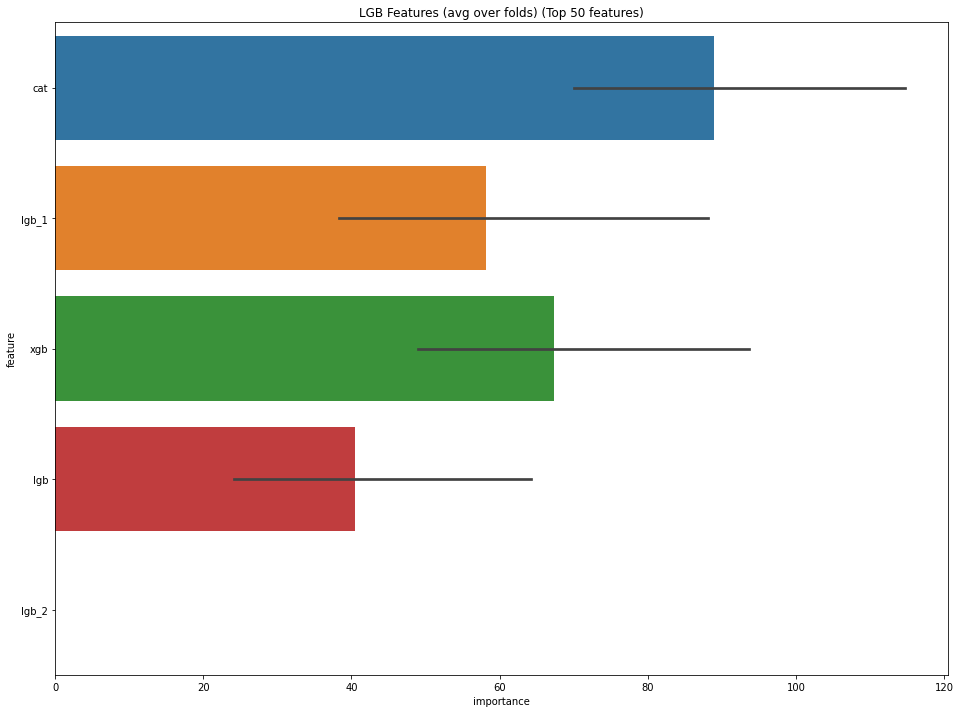

In [0]:
params = {'num_leaves': 8,
          'min_data_in_leaf': 20,
          'objective': 'regression',
          'max_depth': 3,
          'learning_rate': 0.01,
          'boosting': 'gbdt',
          'bagging_seed': 11,
          'metric': 'rmse',
          'lambda_l1': 0.2,
          'verbosity': -1}
oof_lgb_stack, prediction_lgb_stack, feat_imp = train_model(train_stack, test_stack, y, params = params, model_type = 'lgb', plot_feature_importance = True)

* Latest rmse is much better than earlier i.e **1.9717**
* Importance of lgb_2 got as 0.

In [0]:
feat_imp.head()

,feature,importance,fold
0,lgb,22.0,1
1,xgb,43.0,1
2,cat,71.3,1
3,lgb_1,38.2,1
4,lgb_2,0.0,1


#**RidgeCV using stacked data**

In [0]:
model = RidgeCV(alphas = (0.01, 0.1, 1.0, 10.0, 100.0), scoring = 'neg_mean_squared_error', cv = folds)

oof_rcv_stack, prediction_rcv_stack = train_model(train_stack.values, test_stack.values, y, params=None, model_type = 'sklearn', model = model)

Fold 0 started at Thu Jun  4 13:08:38 2020
Fold 1 started at Thu Jun  4 13:08:38 2020
Fold 2 started at Thu Jun  4 13:08:38 2020
Fold 3 started at Thu Jun  4 13:08:39 2020
Fold 4 started at Thu Jun  4 13:08:39 2020
Fold 5 started at Thu Jun  4 13:08:39 2020
Fold 6 started at Thu Jun  4 13:08:39 2020
Fold 7 started at Thu Jun  4 13:08:39 2020
Fold 8 started at Thu Jun  4 13:08:39 2020
Fold 9 started at Thu Jun  4 13:08:39 2020

CV mean score : 1.9695, std: 0.1636.



* We got better result from RidgeCV than LGBM when stacked data is used.2
* **RMSE(LGBM = 1.9717) > RMSE(RidgeCV = 1.9695)**

#**Submission**

* We are saving all our results to the data files.
* But first we download the sample submission file and we modify that.

In [0]:
sample_sub

,id,revenue
0,3001,1000000
1,3002,1000000
2,3003,1000000
3,3004,1000000
4,3005,1000000
...,...,...
4393,7394,1000000
4394,7395,1000000
4395,7396,1000000
4396,7397,1000000


In [0]:
PROJECT_PATH = '/content/drive/My Drive/Colab Notebooks/Works/TMDB Prediction'

In [0]:
PROJECT_PATH

'/content/drive/My Drive/Colab Notebooks/Works/TMDB Prediction'

In [0]:
#saving the lgbm results
sample_sub['revenue'] = np.expm1(prediction_lgb)
sample_sub.to_csv(PROJECT_PATH + '/data/results/lgb_results.csv',  index = False)

#saving mean(prediction_lgbm, prediction_xgb)
sample_sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb) / 2)
sample_sub.to_csv(PROJECT_PATH + '/data/results/blend_results.csv',  index = False)

#saving mean(prediction_lgbm, prediction_xgb, prediction_cat)
sample_sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb + prediction_cat) / 3)
sample_sub.to_csv(PROJECT_PATH + '/data/results/blend1_results.csv',  index = False)

#saving mean(prediction_lgbm, prediction_xgb, prediction_cat, prediction_lgb_1)
sample_sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb + prediction_cat + prediction_lgb_1) / 4)
sample_sub.to_csv(PROJECT_PATH + '/data/results/blend2_results.csv',  index = False)

#saving mean(prediction_lgbm, prediction_xgb, prediction_cat, prediction_lgb_1, prediction_lgb_2)
sample_sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb + prediction_cat + prediction_lgb_1 + prediction_lgb_2) / 5)
sample_sub.to_csv(PROJECT_PATH + '/data/results/blend3_results.csv',  index = False)

#saving stack results
sample_sub['revenue'] = prediction_lgb_stack
sample_sub.to_csv(PROJECT_PATH + '/data/results/stack_lgb_results.csv',  index = False)

sample_sub['revenue'] = prediction_rcv_stack
sample_sub.to_csv(PROJECT_PATH + '/data/results/stack_rcv_results.csv',  index = False)